In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
from matplotlib import pyplot as plt

In [2]:
#read data
batting = pd.read_csv('batting.csv')
display(batting.head())

,playerid,Name,Team,MarApr_PA,MarApr_AB,MarApr_H,MarApr_HR,MarApr_R,MarApr_RBI,MarApr_SB,...,MarApr_FB%,MarApr_IFFB%,MarApr_HR/FB,MarApr_O-Swing%,MarApr_Z-Swing%,MarApr_Swing%,MarApr_O-Contact%,MarApr_Z-Contact%,MarApr_Contact%,FullSeason_OBP
0,15998,Cody Bellinger,LAD,132,109,47,14,32,37,5,...,36.1%,5.7%,40.0%,22.6%,66.0%,40.7%,81.1%,88.4%,86.0%,0.406
1,11477,Christian Yelich,MIL,124,102,36,14,26,34,6,...,41.0%,11.8%,41.2%,27.9%,72.4%,44.8%,56.6%,87.8%,75.7%,0.429
2,17975,Scott Kingery,PHI,35,32,13,2,5,6,1,...,33.3%,0.0%,22.2%,40.2%,74.5%,53.5%,54.3%,85.4%,71.1%,0.315
3,7927,Eric Sogard,TOR,49,43,17,3,8,9,2,...,40.5%,0.0%,20.0%,27.3%,50.5%,37.3%,93.9%,97.8%,96.2%,0.353
4,14130,Daniel Vogelbach,SEA,92,71,22,8,15,16,0,...,51.9%,7.4%,29.6%,23.7%,48.8%,33.7%,66.1%,82.7%,75.7%,0.341


In [3]:
batting.drop(columns = ["playerid","Team"], inplace = True)
batting.set_index('Name', inplace = True)
batting.head()

,MarApr_PA,MarApr_AB,MarApr_H,MarApr_HR,MarApr_R,MarApr_RBI,MarApr_SB,MarApr_BB%,MarApr_K%,MarApr_ISO,...,MarApr_FB%,MarApr_IFFB%,MarApr_HR/FB,MarApr_O-Swing%,MarApr_Z-Swing%,MarApr_Swing%,MarApr_O-Contact%,MarApr_Z-Contact%,MarApr_Contact%,FullSeason_OBP
Name,,,,,,,,,,,,,,,,,,,,,
Cody Bellinger,132,109,47,14,32,37,5,14.4%,11.4%,0.459,...,36.1%,5.7%,40.0%,22.6%,66.0%,40.7%,81.1%,88.4%,86.0%,0.406
Christian Yelich,124,102,36,14,26,34,6,16.1%,16.1%,0.451,...,41.0%,11.8%,41.2%,27.9%,72.4%,44.8%,56.6%,87.8%,75.7%,0.429
Scott Kingery,35,32,13,2,5,6,1,2.9%,14.3%,0.313,...,33.3%,0.0%,22.2%,40.2%,74.5%,53.5%,54.3%,85.4%,71.1%,0.315
Eric Sogard,49,43,17,3,8,9,2,10.2%,10.2%,0.302,...,40.5%,0.0%,20.0%,27.3%,50.5%,37.3%,93.9%,97.8%,96.2%,0.353
Daniel Vogelbach,92,71,22,8,15,16,0,21.7%,21.7%,0.423,...,51.9%,7.4%,29.6%,23.7%,48.8%,33.7%,66.1%,82.7%,75.7%,0.341


In [4]:
#Creating a function to summarize the dataframe
def summarize_dataframe(df):
    """Summarize a dataframe, and report missing values."""
    missing_values = pd.DataFrame({'Variable Name': df.columns,
                                   'Data Type': df.dtypes,
                                   'Missing Values': df.isnull().sum(),
                                   'Unique Values': [df[name].nunique() for name in df.columns]}
                                 ).set_index('Variable Name')
    with pd.option_context("display.max_rows", 1000):
        display(pd.concat([missing_values, df.describe(include='all').transpose()], axis=1).fillna(""))
        
summarize_dataframe(batting)

,Data Type,Missing Values,Unique Values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Variable Name,,,,,,,,,,,,,,
MarApr_PA,int64,0,98,320.0,,,,90.4188,29.4122,30,69,94.5,114.25,135
MarApr_AB,int64,0,97,320.0,,,,80.0719,25.9372,24,61.75,84,102,123
MarApr_H,int64,0,37,320.0,,,,20.4969,8.49193,4,14,20.5,27,47
MarApr_HR,int64,0,13,320.0,,,,3.37188,2.52433,0,1,3,5,14
MarApr_R,int64,0,27,320.0,,,,11.5281,5.75621,1,7,11,15,32
MarApr_RBI,int64,0,29,320.0,,,,11.1312,6.17927,0,6,11,16,37
MarApr_SB,int64,0,11,320.0,,,,1.2125,1.77721,0,0,1,2,10
MarApr_BB%,object,0,133,320.0,133,10.0%,9,,,,,,,
MarApr_K%,object,0,186,320.0,186,25.0%,6,,,,,,,


In [5]:
batting['MarApr_BB%'] = batting['MarApr_BB%'].str.rstrip('%').astype('float') / 100.0
batting['MarApr_K%'] = batting['MarApr_K%'].str.rstrip('%').astype('float') / 100.0
batting['MarApr_LD%'] = batting['MarApr_LD%'].str.rstrip('%').astype('float') / 100.0
batting['MarApr_GB%'] = batting['MarApr_GB%'].str.rstrip('%').astype('float') / 100.0
batting['MarApr_FB%'] = batting['MarApr_FB%'].str.rstrip('%').astype('float') / 100.0
batting['MarApr_IFFB%'] = batting['MarApr_IFFB%'].str.rstrip('%').astype('float') / 100.0
batting['MarApr_HR/FB'] = batting['MarApr_HR/FB'].str.rstrip('%').astype('float') / 100.0
batting['MarApr_O-Swing%'] = batting['MarApr_O-Swing%'].str.rstrip('%').astype('float') / 100.0
batting['MarApr_Z-Swing%'] = batting['MarApr_Z-Swing%'].str.rstrip('%').astype('float') / 100.0
batting['MarApr_Swing%'] = batting['MarApr_Swing%'].str.rstrip('%').astype('float') / 100.0
batting['MarApr_O-Contact%'] = batting['MarApr_O-Contact%'].str.rstrip('%').astype('float') / 100.0
batting['MarApr_Z-Contact%'] = batting['MarApr_Z-Contact%'].str.rstrip('%').astype('float') / 100.0
batting['MarApr_Contact%'] = batting['MarApr_Contact%'].str.rstrip('%').astype('float') / 100.0

In [6]:
preds = [column for column in batting.columns if column not in ('FullSeason_OBP')]
X = batting[preds]
y = batting['FullSeason_OBP']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)

(256, 25)
(64, 25)


In [8]:
from sklearn.ensemble import GradientBoostingRegressor

est = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
max_depth=1, random_state=0, loss='ls').fit(X_train, y_train)
pred4 = est.predict(X_test)
test_set_rmse = (np.sqrt(mean_squared_error(y_test, pred4)))
test_set_r2 = r2_score(y_test, pred4)

print(test_set_rmse)
print(test_set_r2)

0.024740765504572007
0.4076945305719891


In [9]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=7)
xgb.fit(X_train, y_train)
pred = xgb.predict(X_test)
test_set_rmse = (np.sqrt(mean_squared_error(y_test, pred)))
test_set_r2 = r2_score(y_test, pred)

print(test_set_rmse)
print(test_set_r2)

0.024700798476947207
0.40960664345655373


In [10]:
from sklearn import svm
reg = svm.SVR()
reg.fit(X_train,y_train)
pred5 = reg.predict(X_test)
test_set_rmse = (np.sqrt(mean_squared_error(y_test, pred5)))
test_set_r2 = r2_score(y_test, pred5)

print(test_set_rmse)
print(test_set_r2)

0.028119605519933054
0.2348652536667618


In [11]:
from sklearn import tree
dtree = tree.DecisionTreeRegressor()
dtree = dtree.fit(X_train,y_train)
pred2 = dtree.predict(X_test)
test_set_rmse = (np.sqrt(mean_squared_error(y_test, pred2)))
test_set_r2 = r2_score(y_test, pred2)

print(test_set_rmse)
print(test_set_r2)

0.03798190358578675
-0.39595986131572425


In [12]:
lin_r = LinearRegression()
lin_r.fit(X_train, y_train)
pred1 = lin_r.predict(X_test)
test_set_rmse = (np.sqrt(mean_squared_error(y_test, pred1)))
test_set_r2 = r2_score(y_test, pred1)
print(test_set_rmse)
print(test_set_r2)

0.026699514747356136
0.31019519759849157


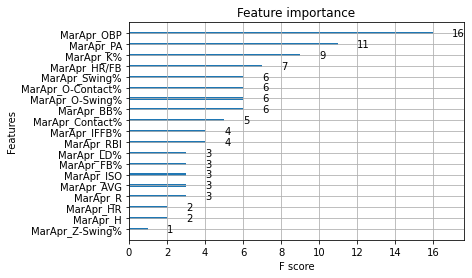

In [13]:
plot_importance(xgb)
#, max_num_features=10
plt.show()

In [20]:
ind_var = ['MarApr_OBP', 'MarApr_PA', 'MarApr_K%', 'MarApr_HR/FB', 'MarApr_Swing%', 'MarApr_O-Contact%', 'MarApr_O-Swing%', 'MarApr_BB%', 'MarApr_Contact%', 'MarApr_IFFB%', 'MarApr_RBI']
X = batting[ind_var]
y = batting['FullSeason_OBP']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

In [21]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=7)
xgb.fit(X_train, y_train)

pred = xgb.predict(X_test)

test_set_rmse = (np.sqrt(mean_squared_error(y_test, pred)))
test_set_r2 = r2_score(y_test, pred)

print(test_set_rmse)
print(test_set_r2)

0.026082582368186735
0.34170485511662074


In [22]:
lin_r = LinearRegression()
lin_r.fit(X_train, y_train)
pred1 = lin_r.predict(X_test)
test_set_rmse = (np.sqrt(mean_squared_error(y_test, pred1)))
test_set_r2 = r2_score(y_test, pred1)
print(test_set_rmse)
print(test_set_r2)

0.024649502409539146
0.41205623319030993


In [17]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)
#lin_reg_mod = LinearRegression()
#lin_reg_mod.fit(X_train, y_train)
#pred1 = lin_reg_mod.predict(X_test)

In [18]:
#preds = [column for column in batting.columns if column not in ('FullSeason_OBP')]
#X = batting[preds]

In [19]:
batting['FullSeason_OBP_Model'] = lin_r.predict(X)
batting.to_csv('batting_model.csv')